In [19]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
reload(utils)

<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.py'>

In [3]:
ntuples = '20170509'
# "%" sign allows to interpret the rest as a system command
print utils.IO.ldata
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
signalName=utils.IO.ldata+ntuples+"/"+''.join(signal)
print "using signal file:"+signalName
background = [s for s in files if "DiPhotonJets" in s]
backgroundName=utils.IO.ldata+ntuples+"/"+''.join(background)
print "using background file:"+backgroundName

/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/
env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509
using signal file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root
using background file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root


In [4]:
import numpy as np

In [5]:
#normal variables: int, float, vectors...
branch_names = 'npu,genTotalWeight'.split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)

#tlorentz vectors
branch_names_lorentz = 'leadingJet,leadingPhoton'.split(",")
branch_names_lorentz = [c.strip() for c in branch_names_lorentz]
branch_names_lorentz = (b.replace(" ", "_") for b in branch_names_lorentz)
branch_names_lorentz = list(b.replace("-", "_") for b in branch_names_lorentz)
print branch_names_lorentz

#variables we want to access in tlorenz vector
branch_names_lorentz_var = 'Pt(),Eta()'.split(",")
branch_names_lorentz_var = [c.strip() for c in branch_names_lorentz_var]
branch_names_lorentz_var = (b.replace(" ", "_") for b in branch_names_lorentz_var)
branch_names_lorentz_var = list(b.replace("-", "_") for b in branch_names_lorentz_var)
print branch_names_lorentz_var

['leadingJet', 'leadingPhoton']
['Pt()', 'Eta()']


In [6]:
import pandas as pd
import root_pandas as rpd
reload(rpd)

# doesn't work the alias bbggSelectionTree.SetAlias("leadingJetPt","leadingJet.Pt()")
#signal_df = rpd.read_root("prova.root","daje", columns = branch_names) 

#this is my modified version of root_pandas library
signal_df = rpd.read_root_LorentzVector(signalName,"bbggSelectionTree", columns = branch_names, columns_lorentz=branch_names_lorentz,columns_lorentz_var=branch_names_\
lorentz_var)
background_df = rpd.read_root_LorentzVector(backgroundName,"bbggSelectionTree", columns = branch_names, columns_lorentz=branch_names_lorentz,columns_lorentz_var=branch_names_\
lorentz_var)
import numpy as np
signal_df.to_csv('/tmp/micheli/prova.csv',',',mode='w')


#signal_df = pd.root2array(signalName, "bbggSelectionTree", branch_names)

leadingJet
leadingJet
leadingPhoton
leadingPhoton
['genWeights', 'genTotalWeight', 'gen_mHH', 'gen_cosTheta', 'gen_NRW', 'leadingPhoton', 'leadingPhotonID', 'leadingPhotonISO', 'leadingPhotonEVeto', 'leadingPhotonIDMVA', 'customLeadingPhotonIDMVA', 'leadingPhotonR9full5x5', 'leadingPhotonHasGain1', 'leadingPhotonHasGain6', 'subleadingPhoton', 'subleadingPhotonID', 'subleadingPhotonISO', 'subleadingPhotonEVeto', 'subleadingPhotonIDMVA', 'customSubLeadingPhotonMVA', 'subleadingPhotonR9full5x5', 'subLeadingPhotonHasGain1', 'subLeadingPhotonHasGain6', 'diphotonCandidate', 'nPromptInDiPhoton', 'leadingJet', 'leadingJet_KF', 'leadingJet_Reg', 'leadingJet_RegKF', 'leadingJet_bDis', 'leadingJet_CSVv2', 'leadingJet_cMVA', 'leadingJet_flavour', 'leadingJet_hadFlavour', 'subleadingJet', 'subleadingJet_KF', 'subleadingJet_Reg', 'subleadingJet_RegKF', 'subleadingJet_bDis', 'subleadingJet_CSVv2', 'subleadingJet_cMVA', 'subleadingJet_flavour', 'subleadingJet_hadFlavour', 'dijetCandidate', 'dijetCandi

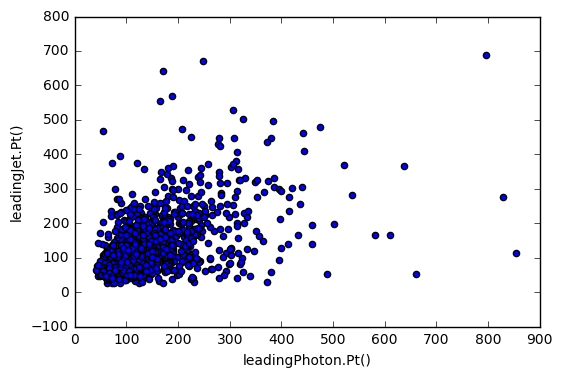

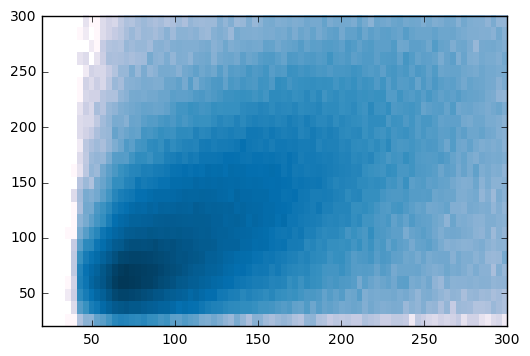

In [7]:
import random
import matplotlib.pyplot as plt
#plot 1000 data points at random
signal_df.ix[random.sample(signal_df.index, 1000)].plot(kind='scatter',
                                          x='leadingPhoton.Pt()', y='leadingJet.Pt()')
plt.show()
from matplotlib.colors import LogNorm
plt.hist2d(x=signal_df['leadingPhoton.Pt()'],y=signal_df['leadingJet.Pt()'],
            range=[[20,300],[20,300]],bins=[80,25],norm=LogNorm(),cmap='PuBu')
plt.show()

In [11]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-4)
import numpy as np
data_train = np.loadtxt( '/tmp/micheli/prova.csv', delimiter=',', skiprows=1 )
# Pick a random seed for reproducible results. Choose wisely!
np.random.seed(42)
# Random number for training/validation splitting
r =np.random.rand(data_train.shape[0])
Y_train = data_train[:,1][r<0.9]
X_train = data_train[:,3:7][r<0.9] 

print Y_train

#gbc = ensemble.GradientBoostingClassifier(n_estimators=50, max_depth=5,min_samples_leaf=200,max_features=10,verbose=1)
#gbc.fit(X_train,Y_train.astype('int')) 

#X = signal_df[['leadingJet.Pt()', 'leadingJet.Eta()', 'leadingPhoton.Pt()', 'leadingPhoton.Eta()']]
#y = signal_df[['npu']]
#W = signal_df[['genTotalWeight']]
#

[ 23.9771862   19.11550331  13.23758411 ...,  22.26027489  21.58580589
  32.31884766]


In [22]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-4)
reg = ensemble.GradientBoostingRegressor(max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-4)

import numpy as np
data_train = np.loadtxt( '/tmp/micheli/prova.csv', delimiter=',', skiprows=1 )
# Pick a random seed for reproducible results. Choose wisely!
np.random.seed(42)
# Random number for training/validation splitting
r =np.random.rand(data_train.shape[0])
Y_train = data_train[:,1][r<0.5]
X_train = data_train[:,3:7][r<0.5] 

import itertools
Y_train_classification_sig = np.asarray(list(itertools.repeat(1, X_train.shape[0])))
#print Y_train_classification_sig


Y_test = data_train[:,1][r>0.5]
X_test = data_train[:,3:7][r>0.5] 


#####interesting part for regression
utils.preprocessing.adjust_and_compress(signal_df).to_hdf('/tmp/micheli/signal.hd5','qcd',compression=9,complib='bzip2',mode='w')
utils.preprocessing.adjust_and_compress(background_df).to_hdf('/tmp/micheli/signal.hd5','qcd',compression=9,complib='bzip2',mode='w')

#adding 1 for sig and 0 for bkg
utils.preprocessing.define_process_weight(signal_df,1,1)
utils.preprocessing.define_process_weight(background_df,0,1)


y_sig = signal_df[['proc']]
y_bkg = background_df[['proc']]
y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg)
#y_total_train = np.concatenate([y_sig,y_bkg])

X_sig = signal_df[['leadingJet.Pt()','leadingPhoton.Pt()']]
X_bkg = background_df[['leadingJet.Pt()','leadingPhoton.Pt()']]
#get first half of sig and background sample
X_total_train = utils.preprocessing.get_total_training_sample(X_sig,X_bkg)




print "total size:"+str(y_total_train.size)
print y_total_train
print type(y_total_train)

print "total size:"+str(X_total_train.size)
print X_total_train

clf.fit(X_total_train,y_total_train)
reg.fit(X_train,Y_train)

X_sig_train = utils.preprocessing.get_training_sample(X_sig)
X_bkg_train = utils.preprocessing.get_training_sample(X_bkg)

X_sig_test = utils.preprocessing.get_test_sample(X_sig)
X_bkg_test = utils.preprocessing.get_test_sample(X_bkg)

Y_pred_sig_train = clf.predict_proba(X_sig_train)
Y_pred_bkg_train = clf.predict_proba(X_bkg_train)

#Y_pred_sig_test = clf.predict(X_sig_test) # predict you get the class 0,1,1, predict_proba you get the classifier output
Y_pred_sig_test = clf.predict_proba(X_sig_test)
Y_pred_bkg_test = clf.predict_proba(X_bkg_test)
print Y_pred_sig_test

305578 Index([u'proc'], dtype='object')152789
train:152789 1221536
611156 Index([u'leadingJet.Pt()', u'leadingPhoton.Pt()'], dtype='object')152789
train:152789 1221536
total size:1374325
[[1]
 [1]
 [1]
 ..., 
 [0]
 [0]
 [0]]
<type 'numpy.ndarray'>
total size:2748650
[[ 110.2707901   251.91912472]
 [  61.87340164   60.23987633]
 [ 164.72155762  141.37246177]
 ..., 
 [  80.06255341   78.05277637]
 [  30.36568642   68.05997782]
 [ 116.55484772   78.45488477]]
[[ 0.25483822  0.74516178]
 [ 0.94291637  0.05708363]
 [ 0.24933332  0.75066668]
 ..., 
 [ 0.55448118  0.44551882]
 [ 0.90325285  0.09674715]
 [ 0.85718907  0.14281093]]


In [10]:
print X_test[:,0].ravel()
plt.hist2d(x=X_test[:,0].ravel(),y=Y_pred, range=[[20,400],[20,50]],bins=[80,25],norm=LogNorm(),cmap='PuBu')
plt.show()
plt.hist2d(x=X_train[:,0].ravel(),y=Y_train, range=[[20,400],[20,50]],bins=[80,25],norm=LogNorm(),cmap='PuBu')
plt.show()

[  61.87340164  164.72155762  103.69889831 ...,   49.01852798  109.16719055
   97.95415497]


NameError: name 'Y_pred' is not defined

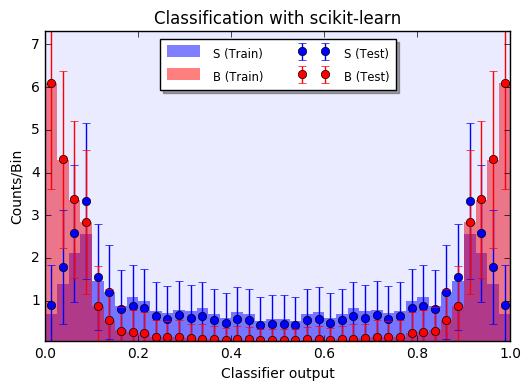

In [25]:

 # This will be the min/max of our plots
c_max = 1.0
c_min = 0.
 
# Get histograms of the classifiers
Histo_training_S = np.histogram(Y_pred_sig_train,bins=40,range=(c_min,c_max),normed=True)
Histo_training_B = np.histogram(Y_pred_bkg_train,bins=40,range=(c_min,c_max),normed=True)
Histo_testing_S = np.histogram(Y_pred_sig_test,bins=40,range=(c_min,c_max),normed=True)
Histo_testing_B = np.histogram(Y_pred_bkg_test,bins=40,range=(c_min,c_max),normed=True)
 
# Lets get the min/max of the Histograms
AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
h_min = min([histo[0].min() for histo in AllHistos])
 
# Get the histogram properties (binning, widths, centers)
bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])
 
# To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
ErrorBar_testing_S = np.sqrt(Histo_testing_S[0]/Y_pred_sig_test.size)
ErrorBar_testing_B = np.sqrt(Histo_testing_B[0]/Y_pred_bkg_test.size)
 
# Draw objects
ax1 = plt.subplot(111)
 
# Draw solid histograms for the training data
ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
 
# # Draw error-bar histograms for the testing data
ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
 
# Make a colorful backdrop to show the clasification regions in red and blue
ax1.axvspan(0.0, c_max, color='blue',alpha=0.08)
ax1.axvspan(c_min,0.0, color='red',alpha=0.08)
 
# Adjust the axis boundaries (just cosmetic)
ax1.axis([c_min, c_max, h_min, h_max])
 
# Make labels and title
plt.title("Classification with scikit-learn")
plt.xlabel("Classifier output")
plt.ylabel("Counts/Bin")
 
# Make legend with smalll font
legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
 
# Save the result to png
plt.savefig("Sklearn_example.png")


'''
plt.hist(Y_pred_sig_train,color='r', alpha=0.5, 
             normed=True,
             label='S (train)')
plt.hist(Y_pred_bkg_train,color='b', alpha=0.5, 
             normed=True,
             label='B (train)')

#err = np.sqrt(h_sig)
#plt.errorbar(h_sig, yerr=0.1, fmt='o', c='r', label='S (test)')
#err = np.sqrt(h_bkg)
#plt.errorbar(h_bkg, yerr=0.1, fmt='o', c='r', label='B (test)')

plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
'''
plt.show()

In [ ]:
plt.hist(Y_pred_sig_test,color='g', alpha=0.5, 
             normed=True,
             label='S (test)')
plt.hist(Y_pred_bkg_test,color='y', alpha=0.5, 
             normed=True,
             label='B (test)')
plt.show()